## Experiment on Langgraph

In [7]:
import sys
sys.path.insert(0,"/Users/user/Documents/agent_rag_langgraph/agent_rag_langgraph")

In [ ]:
from main import retriever


import os
from pprint import pprint
from typing import Literal

from dotenv import load_dotenv
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_openai.chat_models import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from typing import TypedDict

from preprocess import run_preprocess

In [14]:
load_dotenv()  # take environment variables
api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
tools = [retriever]
tool_node = ToolNode(tools)

# # OpenAI LLM model
model = ChatOpenAI(model="gpt-4-turbo", temperature=0, api_key=api_key).bind_tools(
    tools
)
# res = model.invoke("Hi")
# pprint(res.content)

def StateDict(TypedDict):
    messages: list[AnyMessage]

# Function to decide whether to continue or stop the workflow
def should_continue(state: StateDict) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, go to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, finish the workflow
    return END

# Function that invokes the model
def call_model(state: StateDict):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}  # Returns as a list to add to the state

# Define the workflow with LangGraph
workflow = StateGraph(StateDict)

# Add nodes to the graph
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Connect nodes
workflow.add_edge(START, "agent")  # Initial entry
workflow.add_conditional_edges(
    "agent", should_continue
)  # Decision after the "agent" node
workflow.add_edge("tools", "agent")  # Cycle between tools and agent

# Configure memory to persist the state
checkpointer = MemorySaver()

# Compile the graph into a LangChain Runnable application
app = workflow.compile(checkpointer=checkpointer)

# Execute the workflow
final_state = app.invoke(
    {
        "messages": [
            HumanMessage(
                content="""You are an intelligent assistant. Be friendly and use the tools to help you.
                                The tool contain all the insurance details need to know about. Only use these insurance information.
                                Do not hallucinate.If you do not know an answer, reply that you do not know.
                                Question :
                                Tell me more about GREAT Protector Active basic plan"""
            )
        ]
    },
    config={"configurable": {"thread_id": 42}},
)

# Show the final response
print(final_state["messages"][-1].content) # last convo answer only 
print("-------------------------------------------------")
pprint(final_state["messages"]) # last convo 
print("---------------------------------------------------")
# pprint(list(app.get_state_history({"configurable": {"thread_id": 42}}))) # view all the thread convo
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    final_state["messages"]
)  # List of Ragas messages converted using the Ragas function

pprint(ragas_trace)# changes to ragas format 

## Check tool call accuracy 
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
import ragas.messages as r

sample = MultiTurnSample(
user_input=ragas_trace,
reference_tool_calls=[
    r.ToolCall(name="retriever", args={'query': 'GREAT Protector Active basic plan'})
],
)

# tool_accuracy_scorer = ToolCallAccuracy()
# tool_accuracy_scorer.llm = ChatOpenAI(model="gpt-4-turbo")

# print(await tool_accuracy_scorer.multi_turn_ascore(sample))
import asyncio
async def eval_tool_accuracy():
    tool_accuracy_scorer = ToolCallAccuracy()
    tool_accuracy_scorer.llm = ChatOpenAI(model="gpt-4-turbo")

    result = await tool_accuracy_scorer.multi_turn_ascore(sample)
    print(result)
asyncio.run(eval_tool_accuracy())

from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper

async def eval_answer_accuracy():
    sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="details about GREAT Protector Active basic plan",
)

    scorer = AgentGoalAccuracyWithReference()

    evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4-turbo"))
    scorer.llm = evaluator_llm
    result = await scorer.multi_turn_ascore(sample)
    print(result)
asyncio.run(eval_answer_accuracy())

/opt/anaconda3/envs/agent_rag_langgraph_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The GREAT Protector Active basic plan is designed to support an active lifestyle with comprehensive coverage. Here are the key details:

- **Daily Rate**: S$0.89
- **Monthly Rate**: S$27.98
- **Annual Rate**: S$325.99

This plan is part of a personal accident insurance that offers up to S$3 million in coverage against accidents, including Accidental Major Permanent Disablement. This high coverage amount ensures that medical and caregiving expenses can be supported, helping you adjust to lifestyle changes after an accident.

The premium rates include the prevailing rate of GST and are subject to change based on future experiences. The rates are calculated based on the annual premium divided by 365 days and rounded to the nearest cent.

For more specific benefits or conditions, additional details from the policy documents would be required.
-------------------------------------------------
[HumanMessage(content='You are an intelligent assistant. Be friendly and use the tools to help you.

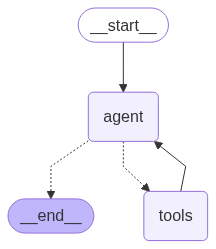

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))